In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as dsp

rst = np.random.RandomState(1)

In [4]:
from PyDynamic.model_estimation.fit_filter import LSFIR
from PyDynamic.uncertainty.propagate_filter import FIRuncFilter
from PyDynamic.misc.SecondOrderSystem import *
from PyDynamic.misc.filterstuff import kaiser_lowpass
from PyDynamic.misc.tools import make_semiposdef

# Design of a digital deconvolution filter (FIR type)

In [5]:
# parameters of simulated measurement
Fs = 500e3
Ts = 1 / Fs

# sensor/measurement system
f0 = 36e3
uf0 = 0.01 * f0
S0 = 0.4
uS0 = 0.001 * S0
delta = 0.01
udelta = 0.1 * delta

# transform continuous system to digital filter
bc, ac = sos_phys2filter(S0, delta, f0)
b, a = dsp.bilinear(bc, ac, Fs)

# Monte Carlo for calculation of unc. assoc. with [real(H),imag(H)]
f = np.linspace(0, 120e3, 200)
Hfc = sos_FreqResp(S0, delta, f0, f)
Hf = dsp.freqz(b, a, 2 * np.pi * f / Fs)[1]

runs = 10000
MCS0 = S0 + rst.randn(runs) * uS0
MCd = delta + rst.randn(runs) * udelta
MCf0 = f0 + rst.randn(runs) * uf0
HMC = np.zeros((runs, len(f)), dtype=complex)
for k in range(runs):
    bc_, ac_ = sos_phys2filter(MCS0[k], MCd[k], MCf0[k])
    b_, a_ = dsp.bilinear(bc_, ac_, Fs)
    HMC[k, :] = dsp.freqz(b_, a_, 2 * np.pi * f / Fs)[1]

H = np.r_[np.real(Hf), np.imag(Hf)]
uAbs = np.std(np.abs(HMC), axis=0)
uPhas = np.std(np.angle(HMC), axis=0)
UH = np.cov(np.hstack((np.real(HMC), np.imag(HMC))), rowvar=0)
UH = make_semiposdef(UH)

Text(0, 0.5, 'magnitude / au')

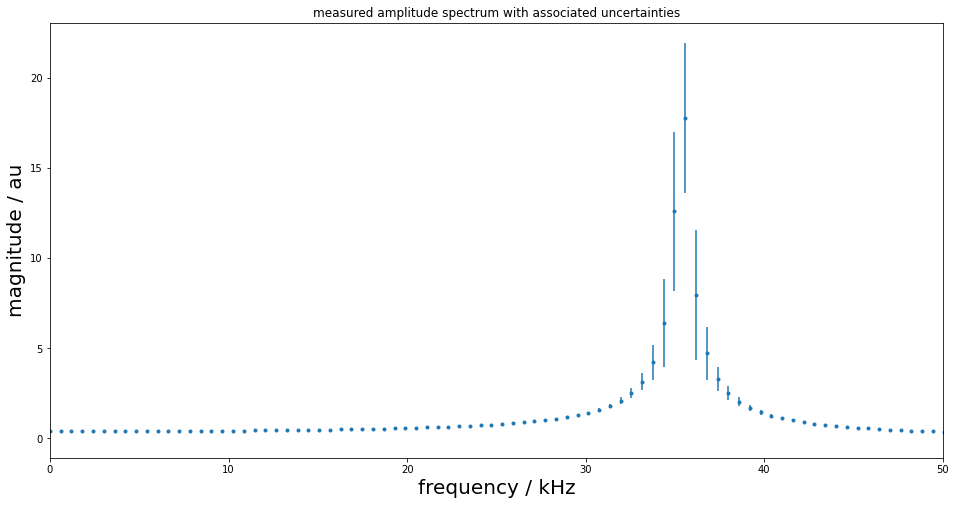

In [6]:
plt.figure(figsize=(16, 8))
plt.errorbar(f * 1e-3, np.abs(Hf), uAbs, fmt=".")
plt.title("measured amplitude spectrum with associated uncertainties")
plt.xlim(0, 50)
plt.xlabel("frequency / kHz", fontsize=20)
plt.ylabel("magnitude / au", fontsize=20)

Text(0, 0.5, 'phase / rad')

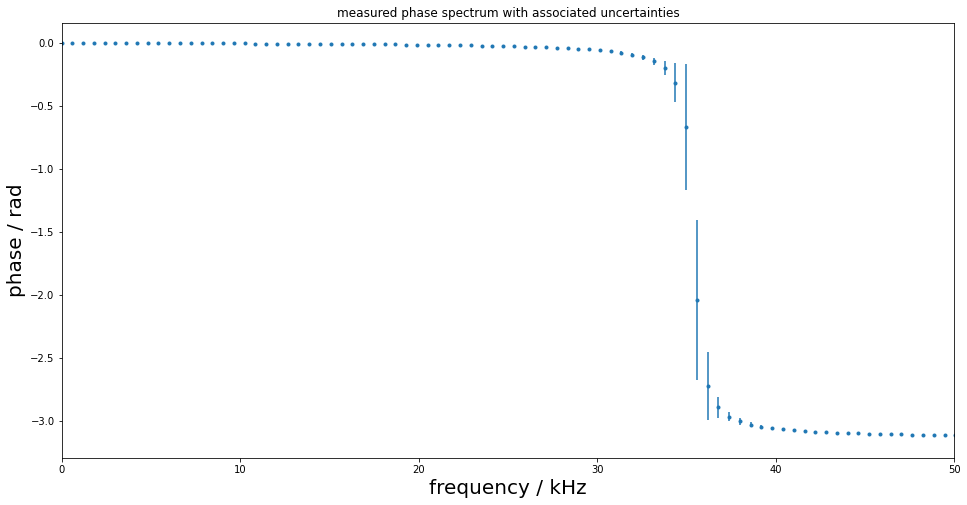

In [7]:
plt.figure(figsize=(16, 8))
plt.errorbar(f * 1e-3, np.angle(Hf), uPhas, fmt=".")
plt.title("measured phase spectrum with associated uncertainties")
plt.xlim(0, 50)
plt.xlabel("frequency / kHz", fontsize=20)
plt.ylabel("phase / rad", fontsize=20)

In [8]:
# simulate input and output signals
time = np.arange(0, 4e-3 - Ts, Ts)
# x = shocklikeGaussian(time, t0 = 2e-3, sigma = 1e-5, m0=0.8)
m0 = 0.8
sigma = 1e-5
t0 = 2e-3
x = (
    -m0
    * (time - t0)
    / sigma
    * np.exp(0.5)
    * np.exp(-((time - t0) ** 2) / (2 * sigma ** 2))
)
y = dsp.lfilter(b, a, x)
noise = 1e-3
yn = y + rst.randn(np.size(y)) * noise

Text(0, 0.5, 'signal amplitude / $m/s^2$')

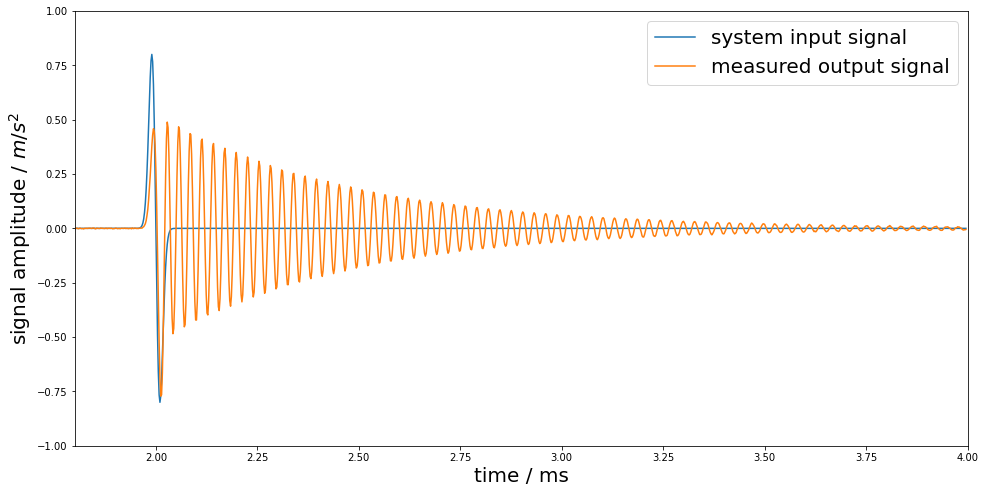

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(time * 1e3, x, label="system input signal")
plt.plot(time * 1e3, yn, label="measured output signal")
plt.legend(fontsize=20)
plt.xlim(1.8, 4)
plt.ylim(-1, 1)
plt.xlabel("time / ms", fontsize=20)
plt.ylabel(r"signal amplitude / $m/s^2$", fontsize=20)

In [10]:
# Calculation of FIR deconvolution filter and its assoc. unc.
N = 12
tau = N // 2
bF, UbF = LSFIR(H, N, f, Fs, tau, inv=True, UH=UH)


LSFIR: Least-squares fit of an order 12 digital FIR filter to the reciprocal of a frequency response given by 400 values. The frequency response's associated uncertainties are propagated via a truncated singular-value decomposition and linear matrix propagation with None as lower bound for the singular values to be considered for the pseudo-inverse.
LSFIR: Calculation of filter coefficients finished. Final rms error = 0.0001934613524619455


Text(0, 0.5, 'FIR coefficient value')

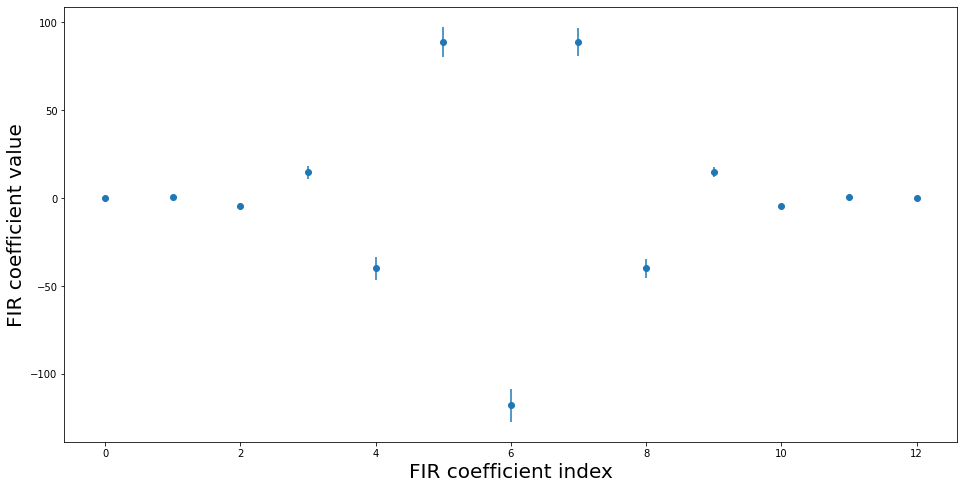

In [11]:
plt.figure(figsize=(16, 8))
plt.errorbar(range(N + 1), bF, np.sqrt(np.diag(UbF)), fmt="o")
plt.xlabel("FIR coefficient index", fontsize=20)
plt.ylabel("FIR coefficient value", fontsize=20)

In [12]:
fcut = f0 + 10e3
low_order = 100
blow, lshift = kaiser_lowpass(low_order, fcut, Fs)
shift = tau + lshift

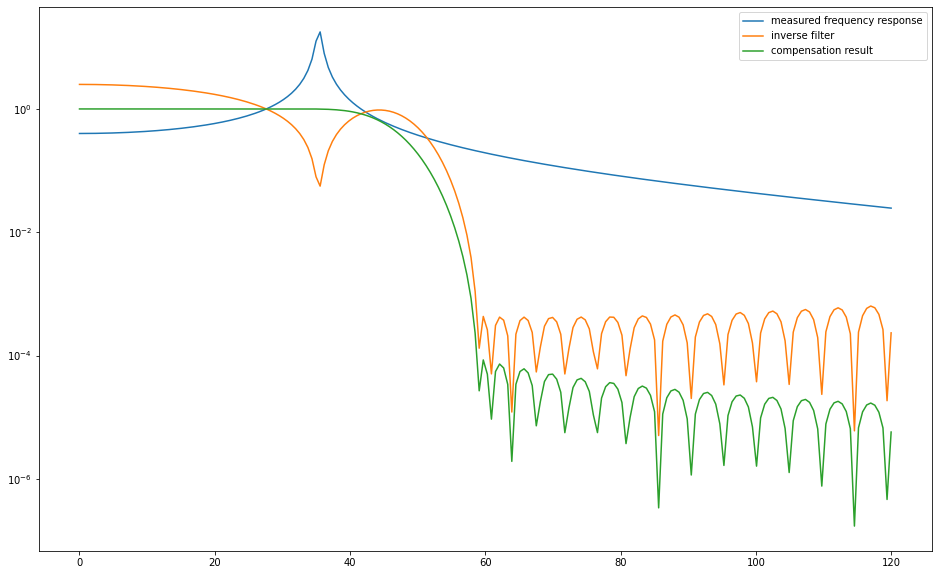

In [13]:
plt.figure(figsize=(16, 10))
HbF = (
    dsp.freqz(bF, 1, 2 * np.pi * f / Fs)[1] * dsp.freqz(blow, 1, 2 * np.pi * f / Fs)[1]
)
plt.semilogy(f * 1e-3, np.abs(Hf), label="measured frequency response")
plt.semilogy(f * 1e-3, np.abs(HbF), label="inverse filter")
plt.semilogy(f * 1e-3, np.abs(Hf * HbF), label="compensation result")
plt.legend()

In [14]:
xhat, Uxhat = FIRuncFilter(yn, noise, bF, UbF, shift, blow)

FIRuncFilter: Output uncertainty will be given as 1D-array of point-wise standard uncertainties. Although this requires significantly lesser computations, it ignores correlation information. Every FIR-filtered signal will have off-diagonal entries in its covariance matrix (assuming the filter is longer than 1). To get the full output covariance matrix, use 'return_full_covariance=True'.


(-1.0, 1.0)

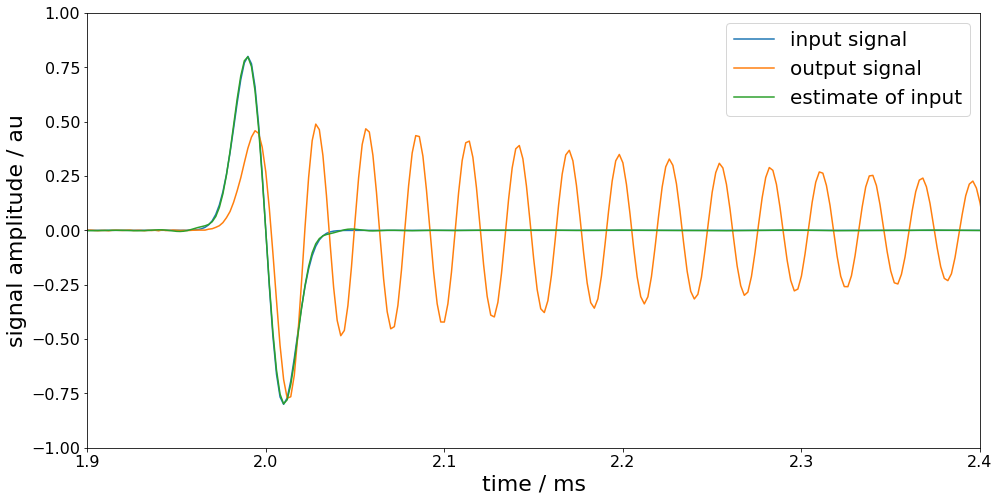

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(time * 1e3, x, label="input signal")
plt.plot(time * 1e3, yn, label="output signal")
plt.plot(time * 1e3, xhat, label="estimate of input")
plt.legend(fontsize=20)
plt.xlabel("time / ms", fontsize=22)
plt.ylabel("signal amplitude / au", fontsize=22)
plt.tick_params(which="both", labelsize=16)
plt.xlim(1.9, 2.4)
plt.ylim(-1, 1)

(1.9, 2.4)

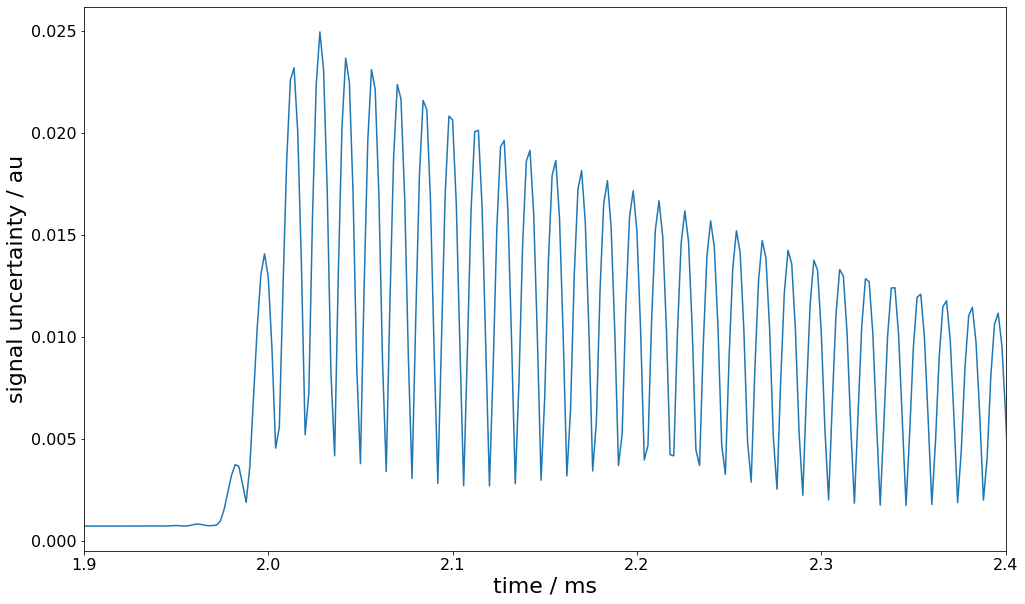

In [16]:
plt.figure(figsize=(16, 10))
plt.plot(time * 1e3, Uxhat)
plt.xlabel("time / ms", fontsize=22)
plt.ylabel("signal uncertainty / au", fontsize=22)
plt.subplots_adjust(left=0.15, right=0.95)
plt.tick_params(which="both", labelsize=16)
plt.xlim(1.9, 2.4)